<a href="https://colab.research.google.com/github/cosmo3769/HubMAP-HPA/blob/main/notebooks/EDA_HuBMAP_HPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [ ]:
import os
import cv2
import glob
import matplotlib
import numpy as np 
import pandas as pd
from tqdm import tqdm
import tifffile as tiff 
import matplotlib.pyplot as plt

# Setting up Wandb

In [ ]:
%%capture
! pip install wandb --upgrade

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Setting up kaggle service to fetch the dataset

Go to your kaggle account. Generate an API token. The file named "kaggle.json" will be downloaded to your local system. Upload the file **kaggle.json** in the colab so to use the kaggle service in colab.  

In [ ]:
# Install the kaggle library.

%%capture
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c hubmap-organ-segmentation

100% 5.76G/5.78G [00:36<00:00, 194MB/s]
100% 5.78G/5.78G [00:36<00:00, 170MB/s]


In [ ]:
%%capture
! unzip hubmap-organ-segmentation.zip

# Directory Path

In [ ]:
TRAIN_PATH = '/content/train_images/'

# Dataset Exploration


In [ ]:
train_df = pd.read_csv("/content/train.csv")
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


### Function to label the bar graph

In [ ]:
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        if type(x[idx]) == int:
          ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                  [x[idx], y[idx]],
                  ha='center', va='bottom', rotation=90)
        else:
          ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                  [x[idx], y[idx]],
                  ha='center', va='bottom', rotation=0)

### Organs Distribution

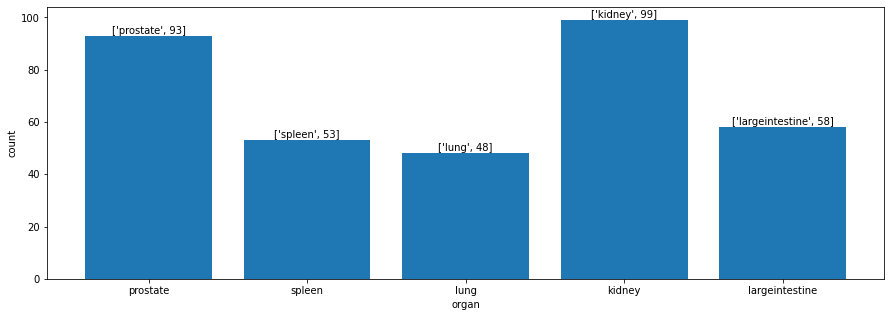

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

x = list(train_df['organ'].unique())
y = list(train_df['organ'].value_counts(sort=False))

bar_plot = plt.bar(x, y)
autolabel(bar_plot)
plt.xlabel('organ')
plt.ylabel('count')
plt.show()

### Age Distribution

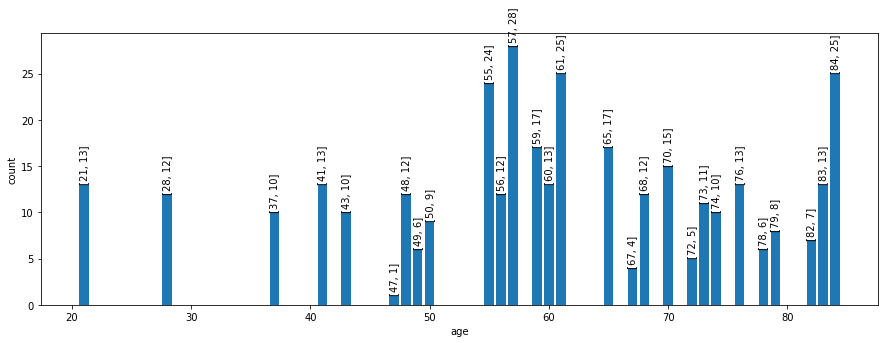

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

x = list(map(int, train_df['age'].unique()))
y = list(train_df['age'].value_counts(sort=False))

bar_plot = plt.bar(x, y)
autolabel(bar_plot)
plt.xlabel('age')
plt.ylabel('count')
plt.show()

### Gender Distribution

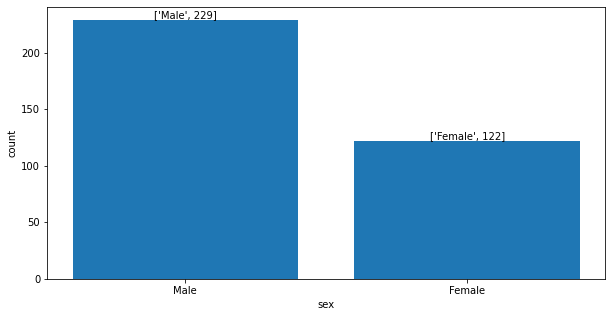

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

x = list(train_df['sex'].unique())
y = list(train_df['sex'].value_counts(sort=False))

bar_plot = plt.bar(x, y)
autolabel(bar_plot)
plt.xlabel('sex')
plt.ylabel('count')
plt.show()

# Image

In [ ]:
image_id_1 = 10044
image_1 = tiff.imread(TRAIN_PATH + str(image_id_1) + ".tiff")
print(image_1.shape)

(3000, 3000, 3)


(-0.5, 2999.5, 2999.5, -0.5)

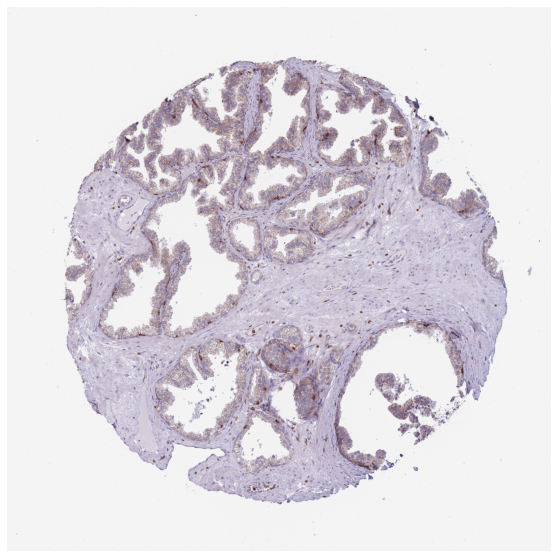

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image_1)
plt.axis("off")

# Mask to RLE & RLE to Mask

In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [ ]:
mask_1 = rle2mask(train_df["rle"][0], (image_1.shape[1], image_1.shape[0]))
mask_1.shape

(3000, 3000)

(-0.5, 2999.5, 2999.5, -0.5)

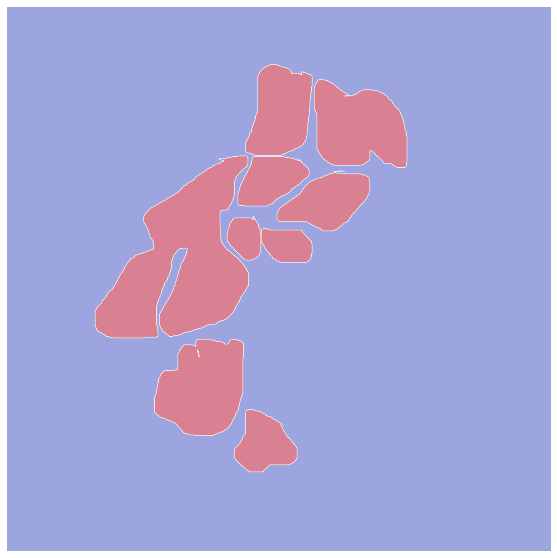

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")

# Combining Mask Image and Original Image

(-0.5, 2999.5, 2999.5, -0.5)

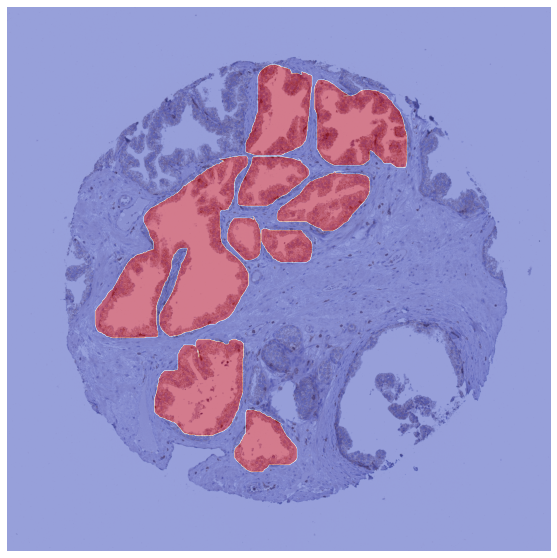

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")

# Adding data to wandb artifacts

In [ ]:
image_files = sorted(glob.glob(TRAIN_PATH+ "*"))
image_file_df = pd.DataFrame(image_files, columns=['file_name'])
train_data = pd.concat([train_df, image_file_df], axis = 1)

In [ ]:
run = wandb.init(project='HuBMAP-HPA', entity='cosmo3769')

data_artifact = wandb.Artifact(name='train', type='RLE-TO-MASK dataset')
data_table = wandb.Table(columns=['image_id', 
                               'image', 
                               'mask', 
                               'masked image', 
                               'organ', 
                               'data source', 
                               'image_height', 
                               'image_width', 
                               'pixel size', 
                               'tissue thickness',
                               'rle',
                               'age',
                               'sex'
                               ])

for i, df in tqdm(train_data.iterrows()):

        img = tiff.imread(df.file_name)
        mask = rle2mask(df.rle[i], (img.shape[1], img.shape[0]))
        
        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.imshow(img)
        plt.imshow(mask, cmap='coolwarm', alpha=0.5)
        plt.savefig(str(df.id) + "_masked.jpg")
        plt.close()

        data_table.add_data(
            df.id,
            wandb.Image(img), 
            wandb.Image(mask),
            wandb.Image(cv2.cvtColor(cv2.imread(str(df.id) + "_masked.jpg"), cv2.COLOR_BGR2RGB)),
            df.organ,
            df.data_source,
            df.img_height,
            df.img_width,
            df.pixel_size,
            df.tissue_thickness,
            df.rle,
            df.age,
            df.sex
        )
    
data_artifact.add(data_table, 'train-RLE-TO-MASK')
run.log_artifact(data_artifact)
wandb.finish()

wandb: Currently logged in as: cosmo3769. Use `wandb login --relogin` to force relogin


302it [32:22,  6.53s/it]